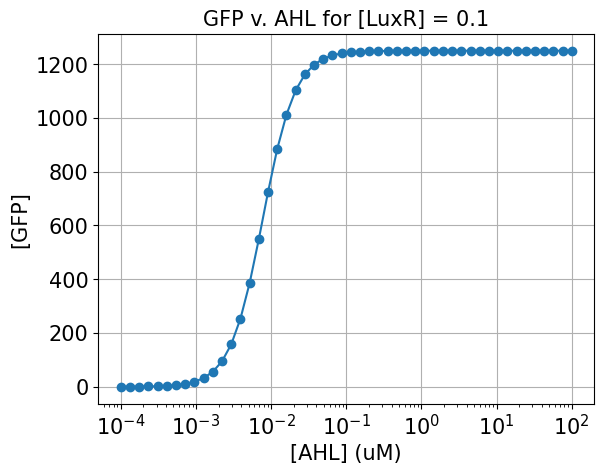

In [48]:
import numpy as np
import matplotlib.pyplot as plt

###### SET UP MODEL FUNCTION with DEFAULTS ######

# Write default values as a dictionary
defaults = {
    # 'c_LUXR_23': 0.1,
    # 'c_LUXR_1': 0.1,
    # 'k_R_12': 1.3e-5,
    # 'k_R_3': 1.3e-5,
    'alp_TXGFP': 0.05,
    'rho_R': 0.5,
    'del_TXGFP': 0.2,
    'del_R': 0.0231,
    'alp_GFP': 2,
    'del_GFP': 4e-4
}
c_LUXR_23s = 0.1 # Starting value for the LuxR constant for strains 2 and 3 (they must change together)
c_LUXR_1s = 0.1 # Starting value for the LuxR constant for strain 1
k_R_12s = 1.3e-5 # Starting value for the K_R constant for strains 2 and 1 (they must change together)
k_R_3s = 1.3e-5 # Starting value for the K_R constant for strain 3

alp_TXGFPs = 0.05
rho_Rs = 0.5
del_TXGFPs = 0.2
del_Rs = 0.0231
alp_GFPs = 2
del_GFPs = 4e-4

def model(C_AHL, C_LuxR, K_R, **kwargs):
    # Set Constant Starting Points depending on the kwargs
    if 'alp_TXGFP' in kwargs:
        alp_TXGFP = kwargs['alp_TXGFP']
    else:
        alp_TXGFP = alp_TXGFPs
    if 'rho_R' in kwargs:
        rho_R = kwargs['rho_R']
    else:
        rho_R = rho_Rs
    if 'del_TXGFP' in kwargs:
        del_TXGFP = kwargs['del_TXGFP']
    else:
        del_TXGFP = del_TXGFPs
    if 'del_R' in kwargs:
        del_R = kwargs['del_R']
    else:
        del_R = del_Rs
    if 'alp_GFP' in kwargs:
        alp_GFP = kwargs['alp_GFP']
    else:
        alp_GFP = alp_GFPs
    if 'del_GFP' in kwargs:
        del_GFP = kwargs['del_GFP']
    else:
        del_GFP = del_GFPs
    if 'n' in kwargs:
        n = kwargs['n']
    else:
        n = 1

    # Calculation
    int_val = rho_R * (C_LuxR**2) * (C_AHL**2) / (del_R * K_R)
    num = alp_GFP * alp_TXGFP * int_val**n
    denom = del_GFP * del_TXGFP * (1 + int_val)**n

    C_GFP = num / denom
    if 'norm' in kwargs:
        if (kwargs['norm'] == False):
            return C_GFP
    return C_GFP / np.max(C_GFP)

# Generate AHL concentrations using logspace
AHL = np.logspace(-4, 2, num=50)  # Adjust 'num' for the number of points

# Calculate GFP concentrations
GFP = model(AHL, 0.1, 1.3e-5, norm=False)

# Plotting
plt.semilogx(AHL, GFP, marker='o')
plt.title('GFP v. AHL for [LuxR] = 0.1', fontsize=15)
plt.xlabel('[AHL] (uM)', fontsize=15)
plt.ylabel('[GFP]', fontsize=15)
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()


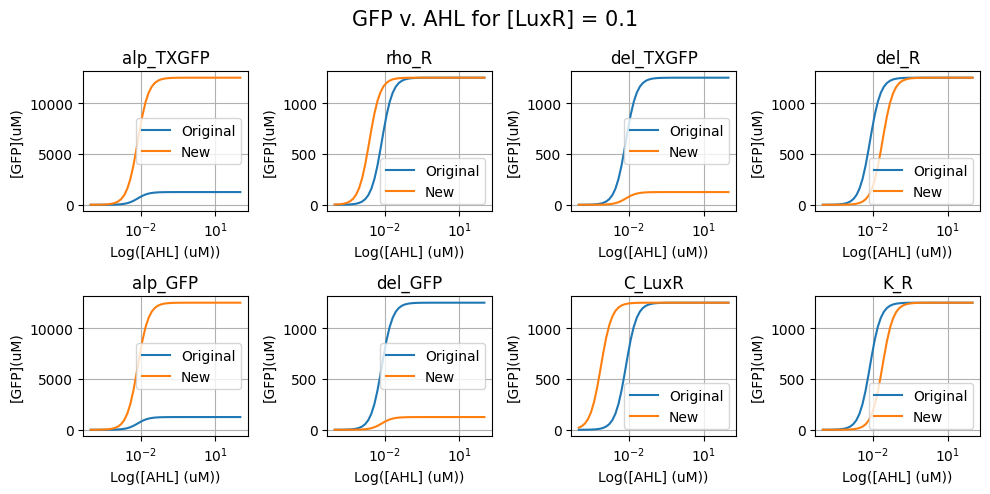

In [49]:
###### CREATE ADDITIONAL PLOTS TO DEMONSTRATE EFFECTS OF PARAMS ######

# Additional 2x4 grid of plots demonstrating how each parameter changing by a factor of 10 affects the graph
fig, axs = plt.subplots(2, 4, figsize=(10, 5))
fig.suptitle('GFP v. AHL for [LuxR] = 0.1', fontsize=15)

# List of params
params = ['alp_TXGFP', 'rho_R', 'del_TXGFP', 'del_R', 'alp_GFP', 'del_GFP', 'C_LuxR', 'K_R']

# For loop to plot each parameter at original and new in the same plot
for i, param in enumerate(params):
    # Original
    GFP = model(AHL, 0.1, 1.3e-5, norm=False)
    axs[i//4, i%4].semilogx(AHL, GFP, label='Original')
    axs[i//4, i%4].set_title(param)
    axs[i//4, i%4].set_xlabel('Log([AHL] (uM))')
    axs[i//4, i%4].set_ylabel('[GFP](uM)')
    axs[i//4, i%4].grid(True)
    # New
    if param in defaults:
        new = defaults[param] * 10
        GFP = model(AHL, 0.1, 1.3e-5, norm=False, **{param: new})
    elif param == 'C_LuxR':
        new = 0.1 * 10
        GFP = model(AHL, new, 1.3e-5, norm=False)
    elif param == 'K_R':
        new = 1.3e-5 * 10
        GFP = model(AHL, 0.1, new, norm=False)
    axs[i//4, i%4].semilogx(AHL, GFP, label='New')
    axs[i//4, i%4].legend()
    axs[i//4, i%4].grid(True)

plt.tight_layout()

In [50]:
##### SET UP DATA AND FITTING #####

import pandas as pd
import numpy as np

# Load the data
data = pd.read_csv('Fluoresence data - Analysis7.csv')

# Filter by 'Strain' column for 1, 2, 3
strain1 = data[data['Strain'] == 1]
strain2 = data[data['Strain'] == 2]
strain3 = data[data['Strain'] == 3]

# Get 'normalized' and 'AHL' columns, and 'normalized 2' column for each strain
normalized11 = pd.to_numeric(strain1['normalized'], errors='coerce')
normalized12 = pd.to_numeric(strain1['normalized 2'], errors='coerce')
ahl1 = pd.to_numeric(strain1['Final AHL'], errors='coerce')

normalized21 = pd.to_numeric(strain2['normalized'], errors='coerce')
normalized22 = pd.to_numeric(strain2['normalized 2'], errors='coerce')
ahl2 = pd.to_numeric(strain2['Final AHL'], errors='coerce')

normalized31 = pd.to_numeric(strain3['normalized'], errors='coerce')
normalized32 = pd.to_numeric(strain3['normalized 2'], errors='coerce')
ahl3 = pd.to_numeric(strain3['Final AHL'], errors='coerce')

# Combine the two normalized columns into a two column matrix
normalized1 = np.array([normalized11, normalized12])
normalized2 = np.array([normalized21, normalized22])
normalized3 = np.array([normalized31, normalized32])

# Get means, normalize, and take stdevs
mean1 = np.mean(normalized1, axis=0)
mean2 = np.mean(normalized2, axis=0)
mean3 = np.mean(normalized3, axis=0)

mean1norm = mean1 / np.max(mean1)
mean2norm = mean2 / np.max(mean2)
mean3norm = mean3 / np.max(mean3)

stdev1 = np.std(normalized1, axis=0)
stdev2 = np.std(normalized2, axis=0)
stdev3 = np.std(normalized3, axis=0)

# Convert to uM
ahl1 = ahl1 * 1e6
ahl2 = ahl2 * 1e6
ahl3 = ahl3 * 1e6

# Create model's AHL concentrations using logspace
AHL = np.logspace(-6, 2, num=50)  # Adjust 'num' for the number of points


In [51]:
##### PREPARE FOR FITTING, GET ORIGINAL RMSEs #####
c_LUXR_23 = c_LUXR_23s
c_LUXR_1 = c_LUXR_1s
k_R_12 = k_R_12s
k_R_3 = k_R_3s

alp_TXGFP = alp_TXGFPs
rho_R = rho_Rs
del_TXGFP = del_TXGFPs
del_R = del_Rs
alp_GFP = alp_GFPs
del_GFP = del_GFPs

# Define RMSE function
def rmse(y, yhat):
    return np.sqrt(np.mean((y - yhat)**2))

# Print all starting RMSEs
print('Starting RMSEs:')
print('Strain 1:', rmse(mean1norm, model(ahl1, c_LUXR_1, k_R_12, alp_TXGFP=alp_TXGFP, rho_R=rho_R, del_TXGFP=del_TXGFP, del_R=del_R, alp_GFP=alp_GFP, del_GFP=del_GFP)))
print('Strain 2:', rmse(mean2norm, model(ahl2, c_LUXR_23, k_R_12, alp_TXGFP=alp_TXGFP, rho_R=rho_R, del_TXGFP=del_TXGFP, del_R=del_R, alp_GFP=alp_GFP, del_GFP=del_GFP)))
print('Strain 3:', rmse(mean3norm, model(ahl3, c_LUXR_23, k_R_3, alp_TXGFP=alp_TXGFP, rho_R=rho_R, del_TXGFP=del_TXGFP, del_R=del_R, alp_GFP=alp_GFP, del_GFP=del_GFP)))

Starting RMSEs:
Strain 1: 0.3483934523445568
Strain 2: 0.12473320219090092
Strain 3: 0.2346065668635309


In [52]:
# Optimization, ensuring all constants are positive and that c_LUXR_23 < c_LUXR_1, k_R_12 < k_R_3
from scipy.optimize import minimize

def opt_fun(x):
    c_LUXR_1, c_LUXR_23, k_R_12, k_R_3, del_R = x
    return rmse(mean1norm, model(ahl1, c_LUXR_1, k_R_12, alp_TXGFP=alp_TXGFP, rho_R=rho_R, del_TXGFP=del_TXGFP, del_R=del_R, alp_GFP=alp_GFP, del_GFP=del_GFP)) + \
        rmse(mean2norm, model(ahl2, c_LUXR_23, k_R_12, alp_TXGFP=alp_TXGFP, rho_R=rho_R, del_TXGFP=del_TXGFP, del_R=del_R, alp_GFP=alp_GFP, del_GFP=del_GFP)) + \
        rmse(mean3norm, model(ahl3, c_LUXR_23, k_R_3, alp_TXGFP=alp_TXGFP, rho_R=rho_R, del_TXGFP=del_TXGFP, del_R=del_R, alp_GFP=alp_GFP, del_GFP=del_GFP))

# Optimize, ensuring all constants are positive and that c_LUXR_23 < c_LUXR_1, k_R_12 < k_R_3
opt = minimize(
    opt_fun,
    x0=[c_LUXR_1, c_LUXR_23, k_R_12, k_R_3,del_R],
    # bounds=[
    #     (0, None),
    #     (0, c_LUXR_1),
    #     (0, k_R_3),
    #     (0, None),
    #     (0, None),
    #     (0, None),
    #     (0, None),
    #     (0, None),
    #     (0, None),
    #     (0, None)
    # ]
)

# Set the optimized parameters
c_LUXR_1 = opt.x[0]
c_LUXR_23 = opt.x[1]
k_R_12 = opt.x[2]
k_R_3 = opt.x[3]
del_R = opt.x[4]

# # Print the new RMSEs
print('New RMSEs:')
print('Strain 1:', rmse(mean1norm, model(ahl1, c_LUXR_1, k_R_12, alp_TXGFP=alp_TXGFP, rho_R=rho_R, del_TXGFP=del_TXGFP, del_R=del_R, alp_GFP=alp_GFP, del_GFP=del_GFP)))
print('Strain 2:', rmse(mean2norm, model(ahl2, c_LUXR_23, k_R_12, alp_TXGFP=alp_TXGFP, rho_R=rho_R, del_TXGFP=del_TXGFP, del_R=del_R, alp_GFP=alp_GFP, del_GFP=del_GFP)))
print('Strain 3:', rmse(mean3norm, model(ahl3, c_LUXR_23, k_R_3, alp_TXGFP=alp_TXGFP, rho_R=rho_R, del_TXGFP=del_TXGFP, del_R=del_R, alp_GFP=alp_GFP, del_GFP=del_GFP)))

# # Print the starting --> optimized parameters
print('Optimized Parameters:')
print('c_LUXR_1:', c_LUXR_1s, '-->', c_LUXR_1)
print('c_LUXR_23:', c_LUXR_23s, '-->', c_LUXR_23)
print('k_R_12:', k_R_12s, '-->', k_R_12)
print('k_R_3:', k_R_3s, '-->', k_R_3)
print('del_R:', del_Rs, '-->', del_R)


# Write about how each parameter affects the model, and why it changed in that direction:
# c_LUXR_1: The LuxR constant for strain 1. Increased to better fit the data.
# c_LUXR_23: The LuxR constant for strains 2 and 3. Increased to better fit the data.

New RMSEs:
Strain 1: 0.041216636220105005
Strain 2: 0.07706603300033046
Strain 3: 0.12723946354044596
Optimized Parameters:
c_LUXR_1: 0.1 --> 0.3678557203937436
c_LUXR_23: 0.1 --> 0.002488114887780604
k_R_12: 1.3e-05 --> 8.943772389141352e-05
k_R_3: 1.3e-05 --> 3.625007060189283e-07
del_R: 0.0231 --> 7.9158219546906e-06


In [53]:
######## CHANGE THE DEFAULTS TO THE OPTIMIZED PARAMETERS ########

c_LUXR_1 = 0.368
c_LUXR_23 = 0.00249
k_R_12 = 8.94e-5
k_R_3 = 3.63e-7
alp_TXGFP = 0.05 # No change
rho_R = 0.5 # No change
del_TXGFP = 0.2 # No change
del_R = 7.91e-6
alp_GFP = 2 # No change
del_GFP = 0.0004 # No change

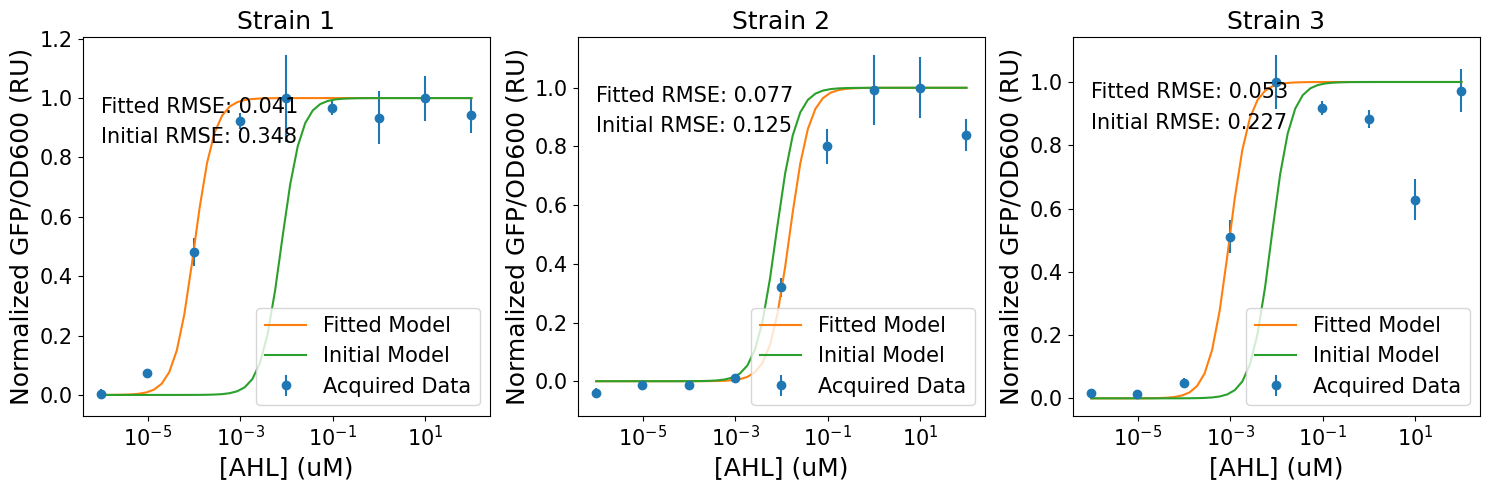

In [54]:
######## PLOT THE FITTED MODEL AGAINST THE DATA ########
main_font_size = 18

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].errorbar(ahl1, mean1norm, yerr=stdev1, fmt='o', label='Acquired Data')
ax[0].semilogx(AHL, model(AHL, c_LUXR_1, k_R_12, del_R=del_R), label='Fitted Model')
ax[0].semilogx(AHL, model(AHL, c_LUXR_1s, k_R_12s), label='Initial Model')
ax[0].set_title('Strain 1', fontsize=main_font_size)
ax[0].set_xlabel('[AHL] (uM)', fontsize=main_font_size)
ax[0].set_ylabel('Normalized GFP/OD600 (RU)', fontsize=main_font_size)
# ax[0].grid(True)
ax[0].legend(fontsize=15)
ax[0].tick_params(labelsize=15)
# Get rid of first elements in mean1norm and ahl1
# mean1norm = mean1norm[3:]
# mean1norm_excluded = mean1norm[:3]
# stddev1_excluded = stdev1[:3]
# ahl1 = ahl1[3:]
# ahl1_excluded = ahl1[:3]

# Replot those points in red
# ax[0].errorbar(ahl1_excluded, mean1norm_excluded, yerr=stddev1_excluded, fmt='o', color='red')
ax[0].text(1e-6, 0.95, 'Fitted RMSE: ' + str(round(rmse(mean1norm, model(ahl1, c_LUXR_1, k_R_12, del_R=del_R)), 3)), fontsize=15)
ax[0].text(1e-6, 0.85, 'Initial RMSE: ' + str(round(rmse(mean1norm, model(ahl1, c_LUXR_1s, k_R_12s)), 3)), fontsize=15)

ax[1].errorbar(ahl2, mean2norm, yerr=stdev2, fmt='o', label='Acquired Data')
ax[1].semilogx(AHL, model(AHL, c_LUXR_23, k_R_12,del_R=del_R), label='Fitted Model')
ax[1].semilogx(AHL, model(AHL, c_LUXR_23s, k_R_12s), label='Initial Model')
ax[1].set_title('Strain 2', fontsize=main_font_size)
ax[1].set_xlabel('[AHL] (uM)', fontsize=main_font_size)
ax[1].set_ylabel('Normalized GFP/OD600 (RU)', fontsize=main_font_size)
# ax[1].grid(True)
# Put leged at bottom right
ax[1].legend(fontsize=15, loc='lower right')
ax[1].tick_params(labelsize=15)
ax[1].text(1e-6, 0.95, 'Fitted RMSE: ' + str(round(rmse(mean2norm, model(ahl2, c_LUXR_23, k_R_12, del_R=del_R)), 3)), fontsize=15)
ax[1].text(1e-6, 0.85, 'Initial RMSE: ' + str(round(rmse(mean2norm, model(ahl2, c_LUXR_23s, k_R_12s)), 3)), fontsize=15)

ax[2].errorbar(ahl3, mean3norm, yerr=stdev3, fmt='o', label='Acquired Data')
ax[2].semilogx(AHL, model(AHL, c_LUXR_23, k_R_3, del_R=del_R), label='Fitted Model')
ax[2].semilogx(AHL, model(AHL, c_LUXR_23s, k_R_3s), label='Initial Model')
ax[2].set_title('Strain 3', fontsize=main_font_size)
ax[2].set_xlabel('[AHL] (uM)', fontsize=main_font_size)
ax[2].set_ylabel('Normalized GFP/OD600 (RU)', fontsize=main_font_size)
# ax[2].grid(True)
ax[2].legend(fontsize=15)
ax[2].tick_params(labelsize=15)
# Get rid of first two elements in mean3norm and ahl3
mean3norm = mean3norm[2:]
ahl3 = ahl3[2:]
# Replot second to last point in red
# ax[2].errorbar(ahl3[-1], mean3norm[-1], yerr=stdev3[-1], fmt='o', color='red')
ax[2].text(1e-6, 0.95, 'Fitted RMSE: ' + str(round(rmse(mean3norm, model(ahl3, c_LUXR_23, k_R_3, del_R=del_R)), 3)), fontsize=15)
ax[2].text(1e-6, 0.85, 'Initial RMSE: ' + str(round(rmse(mean3norm, model(ahl3, c_LUXR_23s, k_R_3s)), 3)), fontsize=15)
# Increase space between subplots
plt.tight_layout()

plt.show()

In [55]:
######### MATHEMATICALLY IDENTIFY SWITCH POINTS #########

print('Switch Points:')

# Get point where normalized fluorescence is 0.5
s1halfmax = AHL[np.argmin(np.abs(model(AHL, c_LUXR_1, k_R_12, del_R=del_R) - 0.5))]
s2halfmax = AHL[np.argmin(np.abs(model(AHL, c_LUXR_23, k_R_12, del_R=del_R) - 0.5))]
s3halfmax = AHL[np.argmin(np.abs(model(AHL, c_LUXR_23, k_R_3, del_R=del_R) - 0.5))]

print('Strain 1:', s1halfmax, 'uM')
print('Strain 2:', s2halfmax, 'uM')
print('Strain 3:', s3halfmax, 'uM')

Switch Points:
Strain 1: 9.102981779915228e-05 uM
Strain 2: 0.017575106248547894 uM
Strain 3: 0.000868511373751352 uM
